# HW7-Part2_Myunghee_ID_2446752777

# 2. (Deep) CNNs for Image Colorization

(a) This assignment uses a convolutional neural network for image colorization which turns a grayscale image to a colored image.5 By converting an image to grayscale, we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [1]:
import numpy as np
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt

(X_tr, y_tr), (X_te, y_te) = cifar10.load_data()

Using TensorFlow backend.


(b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [2]:
# class birds: label 2

index_tr = [] # indexes of not bird class
index_te = []
for i in range(len(y_tr)):
    if y_tr[i][0] != 2:
        index_tr.append(i)
        
for i in range(len(y_te)):
    if y_te[i][0] != 2:
        index_te.append(i)     

In [3]:
train = np.delete(X_tr, index_tr, 0)
test = np.delete(X_te, index_te, 0)

data = np.concatenate((train, test), axis=0)

In [4]:
data.shape

(6000, 32, 32, 3)

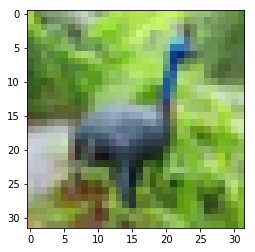

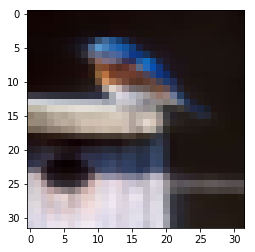

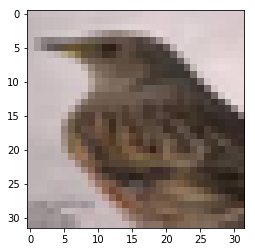

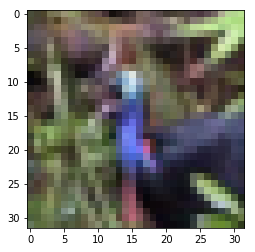

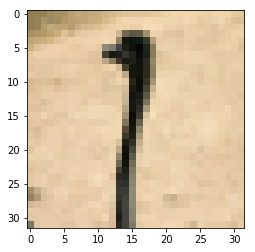

In [5]:
# original 5 images
for i in range(5):
    plt.imshow(data[i])
    plt.show()

(c) Those 6000 images have 6000×32×32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

(d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.6 

6Centers of clusters have been reported too close previously, so the resultant tetra-chrome images will be very close to grayscale. In case you would like to see colorful images, repeat the exercise with colors you select from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/ or https://www.rapidtables.com/web/color/RGB_Color.html. A suggestion would be Navy = (0,0,128), Red =( 230, 25, 75), Mint = (170, 255, 195), and White = (255, 255, 255).

In [6]:
x, y, z, w = data.shape

image_2d = data.reshape(x*y*z, w)

print(image_2d.shape)

(6144000, 3)


In [7]:
# using all pixels
# k-menas clustering (k = 4)
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=4)
kmeans.fit(image_2d)
km_centers = kmeans.cluster_centers_
km_labels = kmeans.labels_

In [8]:
# The centers of the clusters
km_centers

array([[206.19286799, 211.45988616, 211.09816709],
       [108.31555119, 108.00498427,  82.22455168],
       [155.84148225, 155.08636391, 134.84786352],
       [ 48.59727826,  49.58097489,  38.23874448]])

In [9]:
# The centers of the clusters: main colors
km_centers = km_centers.astype(int)
print(km_centers)

[[206 211 211]
 [108 108  82]
 [155 155 134]
 [ 48  49  38]]


In [10]:
# converting the colored images to k-color images 
km_data=km_centers[km_labels]
km_data =km_data.reshape(x, y, z, w)

In [11]:
km_data.shape

(6000, 32, 32, 3)

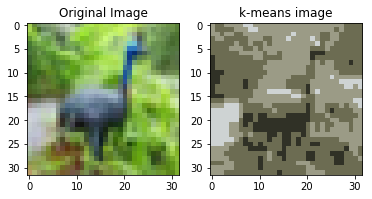

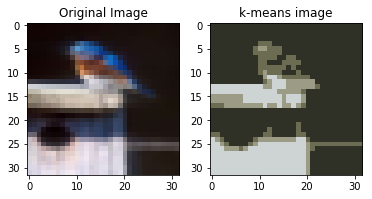

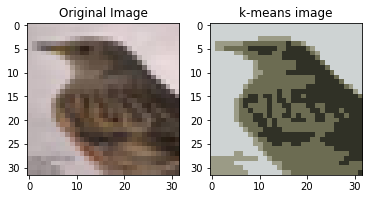

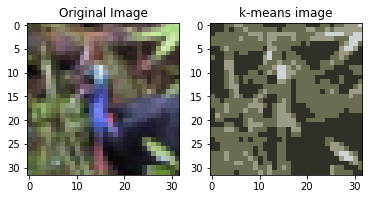

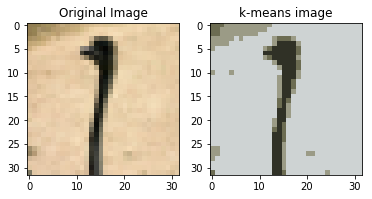

In [12]:
for i in range(5):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.imshow(data[i])
    ax1.set_title('Original Image')
    ax2.imshow(km_data[i])
    ax2.set_title('k-means image')

    plt.show()

(e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32×32×1 images from the original 32×32×3 images. The grayscale images are inputs of your network. 

In [13]:
import cv2
# creating grayscale data
gray_data=np.zeros((data.shape[0],data.shape[1],data.shape[2]))
for i in range(data.shape[0]):
    gray_data[i] = cv2.cvtColor(data[i], cv2.COLOR_BGR2GRAY)

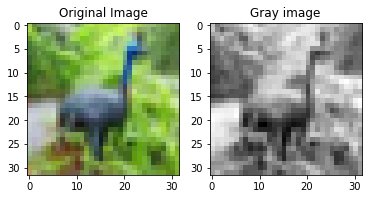

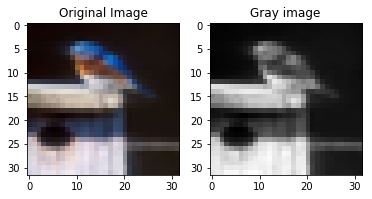

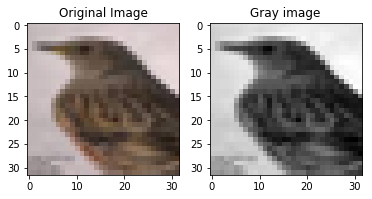

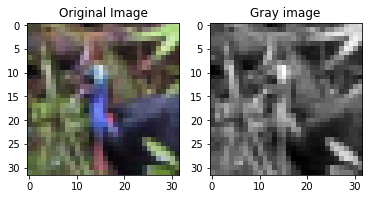

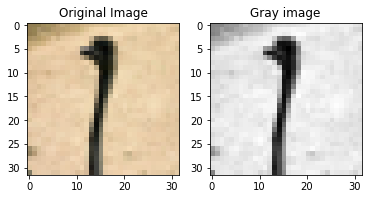

In [14]:
for i in range(5):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.imshow(data[i])
    ax1.set_title('Original Image')
    ax2.imshow(gray_data[i],cmap='gray')
    ax2.set_title('Gray image')

    plt.show()

(f) Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers. Use 5 × 5 ﬁlters and a softmax output layer. Determine the number of ﬁlters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Use a classiﬁcation scheme, which means your output must determine one of the k = 4 color classes for each pixel in your grayscale image. Your input is a grayscale version of an image (32×32×1) and the output is 32 × 32 × 4. The output assigns one of the k = 4 colors to each of the 32×32 pixels; therefore, each of the pixels is classiﬁed into one of the classes [1 0 0 0],[0 1 0 0],[0 0 1 0],[0 0 0 1]. After each pixel is classiﬁed into one of the main colors, the RGB code of that color can be assigned to the pixel. For example, if the third main color7 is [255 255 255] and pixel (32,32) of an image has the one-hot encoded class [0 0 1 0], i.e it was classiﬁed as the third color, the (32,32) place in the output can be associated with [255 255 255]. The size of the output of the convolutional part, c1×c2 depends on the size of the convolutional layers you choose and is a feature map, which is a matrix. That matrix must be ﬂattened or reshaped, i.e. must be turned into a vector of size c1c2×1, before it is fed to the MLP part. Choose the number of neurons in the ﬁrst layer of the MLP (and any other hidden layers, if you are willing to have more than one hidden layer) yourself, but the last layer must have 32×32×4 = 4096 neurons, each of which represents a pixel being in one of the k = 4 classes. Add a softmax layer8 which will choose the highest value out of its k = 4 inputs for each of the 1024 pixels; therefore, the output of the MLP has to be reshaped into a 32×32×4 matrix, and to get the colored image, the RGB vector of each of the k = 4 classes has to be converted to the RGB vector, so an output image will be 32×32×3. Train at least for 5 epochs (30 epochs is strongly recommended).

7Do not use the original CIFAR-10 images as the output. You must use the tetrachrome images you created as your output. 

8Compile the network with loss = cross entropy.

In [15]:
X_tr = gray_data[:5000]
X_te = gray_data[5000:]

X_train = X_tr.reshape(5000,32,32, 1)
X_test = X_te.reshape(1000,32,32,1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [16]:
y_tr = km_labels[:5000*32*32]
y_te = km_labels[5000*32*32:]

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_tr)
y_test = keras.utils.to_categorical(y_te)

y_train=y_train.reshape(5000,32*32*4)
y_test=y_test.reshape(1000,32*32*4)

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Activation, Dense

# conv1, relu, conv2, relu, pool1, 2 MLP, softmax output
# refer to https://keras.io/examples/cifar10_cnn/

clf = Sequential()
# the first convolution and maxPooling
clf.add(Conv2D(64, (5, 5), strides = 1, padding='same',input_shape=(32,32,1)))
clf.add(Activation('relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))

# the second convolution
clf.add(Conv2D(32, (5, 5), strides = 1, padding='same'))
clf.add(Activation('relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))

clf.add(Flatten())

# 2 MLP layers
clf.add(Dense(32*32))
clf.add(Activation('relu'))
clf.add(Dense(32*32*4))
clf.add(Activation('softmax'))

# compiling
clf.compile(loss='categorical_crossentropy',\
              optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
clf.fit(X_train, y_train, batch_size=32,\
              epochs=30, validation_data=(X_test, y_test), shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 5000 samples, validate on 1000 samples
Epoch 1/30
5000/5000 [==============================] - 39s 8ms/step - loss: 8228.7320 - acc: 0.0016 - val_loss: 8030.5091 - val_acc: 0.0000e+00
Epoch 2/30
5000/5000 [==============================] - 42s 8ms/step - loss: 7974.8514 - acc: 4.0000e-04 - val_loss: 7927.5570 - val_acc: 1.0000e-03
Epoch 3/30
5000/5000 [==============================] - 44s 9ms/step - loss: 7897.1797 - acc: 8.0000e-04 - val_loss: 7904.1317 - val_acc: 0.0000e+00
Epoch 4/30
5000/5000 [==============================] - 43s 9ms/step - loss: 7856.3244 - acc: 1.0000e-03 - val_loss: 7858.2242 - val_acc: 0.0000e+00
Epoch 5/30
5000/5000 [==============================] - 40s 8ms/step - loss: 7821.5853 - acc: 2.0000e-04 - val_loss: 7841.2467 - val_acc: 0.0030
Epoch 6/30
5000/5000 [==============================] - 41s 8ms/step - loss: 7794.7773 - acc: 2.0000e-04 - val_loss: 7827.8590 - val_acc: 0.0000e+00
Epoch 7/30
5000/50

2. (f) Plot training, (validation), and test errors in each epoch. 

In [19]:
import pandas as pd
history = clf.history.history

err = dict()
for i in range(30):
    a = 1-history['acc'][i]
    b = 1-history['val_acc'][i]
    err[i+1]=a, b

err_table = pd.DataFrame(err, index=['train','test']).T
err_table.columns.name='epoch'

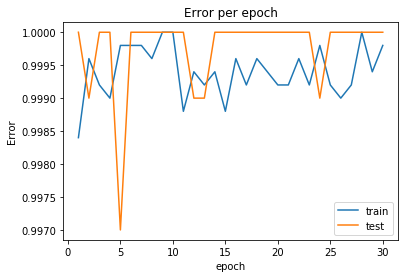

In [20]:
# summarize history for accuracy
plt.plot(err_table.loc[:,'train'])
plt.plot(err_table.loc[:,'test'])
plt.title('Error per epoch')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

2. (f) Report the train and test errors 

In [21]:
err_table

epoch,train,test
1,0.9984,1.000
2,0.9996,0.999
3,0.9992,1.000
4,0.9990,1.000
5,0.9998,0.997
6,0.9998,1.000
7,0.9998,1.000
8,0.9996,1.000
9,1.0000,1.000
10,1.0000,1.000


2. (f) visually compare the artiﬁcially colored versions of the ﬁrst 10 images in the test set with the original images. 

9If you are using matplotlib, you may get a ﬂoating point error because to print an image, matplotlib either expects ints in range 0-255 or ﬂoats in range 0-1. You might be having, for example, 153.0 representation of 153 in your array and this is what makes matplotlib think that you are sending ﬂoats. Wrap your array into np.uint8(). It will convert 153.0 into 153. NOTE that you cannot use np.round or np.int etc because matplotlib’s requirement is unsigned int of 8 bit (think 0-255).

In [22]:
pred_train = clf.predict(X_train, verbose=0)
pred_test = clf.predict(X_test, verbose=0)
pred_train =pred_train.reshape(5000*4096)
pred_test =pred_test.reshape(1000*4096)

In [23]:
labels_train = np.zeros((int(5000*4096/4)), dtype=np.uint8)
labels_test = np.zeros((int(1000*4096/4)), dtype=np.uint8)

In [24]:
for i in range(len(labels_train)):
    labels_train[i] = np.argmax(pred_train[4*i:4*i+4])

for i in range(len(labels_test)):
    labels_test[i] = np.argmax(pred_test[4*i:4*i+4])

In [25]:
cnn_test=km_centers[labels_test]
cnn_test =cnn_test.reshape(1000, y, z, w)

In [26]:
# assigned colors
# Navy = (0,0,128), Red =( 230, 25, 75), Mint = (170, 255, 195), and White = (255, 255, 255)

new_rgb=np.array([[0,0,128],[230,25,75],[170,255,195],[255,255,255]])
art_image=new_rgb[labels_test]
art_image=art_image.reshape(1000,y,z,w)

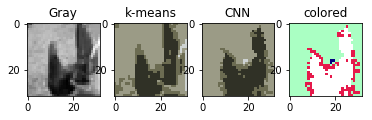

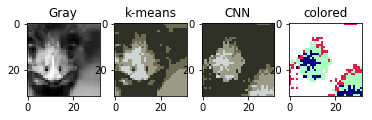

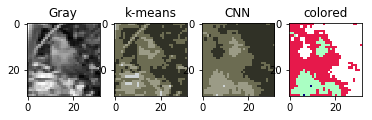

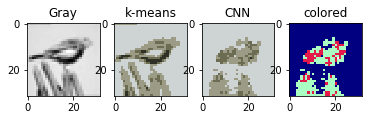

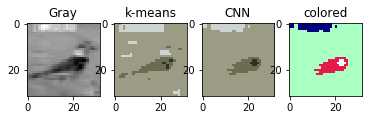

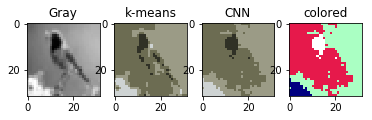

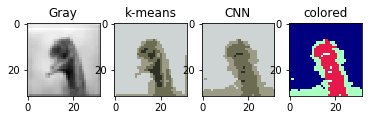

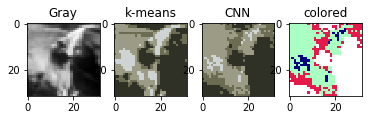

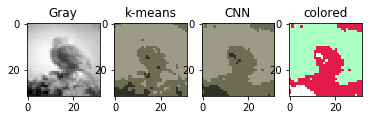

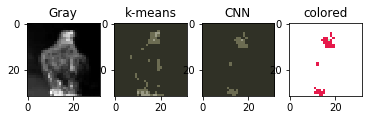

In [27]:
for i in range(10):
    fig, (ax1, ax2,ax3, ax4) = plt.subplots(nrows=1, ncols=4)
    ax1.imshow(X_te[i],cmap='gray')
    ax1.set_title('Gray')
    
    ax2.imshow(km_data[5000+i])
    ax2.set_title('k-means')

    ax3.imshow(cnn_test[i])
    ax3.set_title('CNN')
    
    ax4.imshow(art_image[i])
    ax4.set_title('colored')

    plt.show()